# Strategic Location for Purchasing a Residential Property for Short-term Rent Out (Airbnb) 
## Background / Business Problem
Airbnbs are becoming more popular. They offer cheap short-term stay while providing the convinience of a complete property. However, they need to compete with the hotels in their vicinity. Hotels often host a restaurant which could be an important factor for those who care about having their meals close to their temporary location. Hence, for an Airbnb to be attractive enough for these kind of tourists, the number of restaurants in the neighborhood is of high importance. 

### Business Problem: 
A client is looking for the best neighbourhood to purchase a residential property to rent out as an Airbnb. Where could they purchase a rather cheap property which could attract a reasonable amount of tenants. Our reasoning would be based on number of hotels in the neighbourhood (which indicates level of competition), number of restaurants in the area (as an highly influential factor when choosing an Airbnb), and price of the residential properties in the area (as a decision factor for the client). 

In this analysis, the influence of other Airbnbs in the area is neglected. Furthermore, other factors to choose an Airbnb such as number of point-of-interests, museums, etc. are not included in this research. We also neglect the effect of costly restaurants and treat all restaurants as equally influential on the choise of Airbnb location. 

## Data
Foursquare API will be used to fetch data on venues in the neighbourhoods of Toronto. Neighbourhood names will be retrieved and scraped from Wikipedia (https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050) based on their borough and postal codes.

To find out the price of residential properties in Toronto we use the data file provided in the following address which gives us the price, neighbourhood, and geo-coordinates of many residentials properties in Toronto: https://www.kaggle.com/mnabaee/ontarioproperties 

Although the data is from 2016, we can still use it for today's comparison since the goal is to compare different neighbourhoods' price level. We assume the residential properties are representitive and sufficient for our conclusion. 

In [1]:
# import the library we use to open URLs
import urllib.request

In [2]:
!conda install -c conda-forge geopy --yes

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
import lxml.html as lh
import requests
import pandas as pd
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)
#Store the contents of the website
data = lh.fromstring(page.content)
#Store table data
tr_elements = data.xpath('//tr')
col=[]
ind=0
#store each first element and an empty list for each row
for i in tr_elements[0]:
    ind= ind + 1
    name = i.text_content()
    col.append((name,[]))
#Since the first row is header, data is stored from the second row
for i in range(1,len(tr_elements)):
    T=tr_elements[i]
    
    #If row is not of size 3, then tr data is not from our table 
    if len(T)!=3:
        break
    #i is the index of our column
    ind=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        temp=t.text_content() 
        #Check if row is empty
        if ind>0:
        #Convert any numerical value to integers
            try:
                temp=int(temp)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[ind][1].append(temp)
        #Increment i for the next column
        ind = ind + 1
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.head()

,Postal Code\n,Borough\n,Neighbourhood\n
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


In [5]:
df['Postal Code\n']=df['Postal Code\n'].str.replace('\n', '')
df['Borough\n']=df['Borough\n'].str.replace('\n', '')
df['Neighbourhood\n']=df['Neighbourhood\n'].str.replace('\n', '')
df.rename(columns={'Postal Code\n': 'Postal Code', 'Borough\n': 'Borough', 'Neighbourhood\n': 'Neighbourhood'}, inplace = True)
df = df[df.Borough != 'Not assigned']
df = df.reset_index(drop=True)
#!conda install -c conda-forge geocoder -y
import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude


latitude=[]
longitude=[]
for code in df['Postal Code']:
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
    #print(code, g.latlng)
    while (g.latlng is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
        #print(code, g.latlng)
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])
    
df['Latitude'] = latitude
df['Longitude'] = longitude

df = df[~df.Borough.str.contains("Canadian postal codes")]
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


# NEW ASSIGNMENT

In [6]:
# load housing price of Ontario
prop_path = pd.read_csv('properties.csv')
df_prop = pd.DataFrame(prop_path)

# Only keep rows which are in Toronto, ON
df_prop = df_prop[df_prop.Address.str.contains("Toronto, ON")]
df_prop.drop('Unnamed: 0', inplace=True, axis=1)

# Lets see how our data looks like
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5087 entries, 0 to 24114
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Address    5087 non-null   object 
 1   AreaName   5087 non-null   object 
 2   Price ($)  5087 non-null   int64  
 3   lat        5087 non-null   float64
 4   lng        5087 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 238.5+ KB


In [7]:
df_prop = df_prop[~(df_prop['Price ($)'] <= 50000)]  
df_prop.head()

,Address,AreaName,Price ($),lat,lng
0,"86 Waterford Dr Toronto, ON",Richview,999888,43.679882,-79.544266
4,"#1409 - 230 King St Toronto, ON",Downtown,362000,43.651478,-79.368118
5,"254A Monarch Park Ave Toronto, ON",Old East York,1488000,43.686375,-79.328918
12,"3 Bracebridge Ave Toronto, ON",Old East York,599900,43.697842,-79.317368
15,"#710 - 1080 Bay St Toronto, ON",Downtown,805900,43.666794,-79.388756


In [8]:
df_prop_meanArea = df_prop.groupby(['AreaName']).agg(['mean', 'count'])
#df_prop_meanArea_grp = df_prop.groupby(['AreaName'])
df_prop_meanArea_lng = df_prop_meanArea['lng', 'mean']
df_prop_meanArea_lat = df_prop_meanArea['lat', 'mean']

In [9]:
def search(sTerm):
     distance = (df_prop_meanArea_lat[sTerm]-df['Latitude'])**2+(df_prop_meanArea_lng[sTerm]-df['Longitude'])**2
     val, idx = min((val, idx) for (idx, val) in enumerate(distance))
     df_prop['AreaName'] = df_prop['AreaName'].replace([sTerm],df.loc[idx].Neighbourhood)

In [10]:
for sTerm in set(df_prop['AreaName']):
    search(sTerm)

In [11]:
#df_prop_price = df_prop.groupby(['AreaName']).agg(['mean', 'count'])
df_prop_price = df_prop.groupby(['AreaName'], as_index=False).mean()

In [12]:
df_prop_price.head()

,AreaName,Price ($),lat,lng
0,Agincourt,4.858069e+05,43.788156,-79.275022
1,"Alderwood, Long Branch",9.331101e+05,43.597581,-79.537125
2,"Bathurst Manor, Wilson Heights, Downsview North",8.759328e+05,43.756574,-79.451051
3,Bayview Village,6.717563e+05,43.770260,-79.378451
4,"Bedford Park, Lawrence Manor East",2.037382e+06,43.731151,-79.424741


In [13]:
df_prop_price.rename(columns={'AreaName': 'Neighbourhood'}, inplace=True)
df_prop_price.head()

,Neighbourhood,Price ($),lat,lng
0,Agincourt,4.858069e+05,43.788156,-79.275022
1,"Alderwood, Long Branch",9.331101e+05,43.597581,-79.537125
2,"Bathurst Manor, Wilson Heights, Downsview North",8.759328e+05,43.756574,-79.451051
3,Bayview Village,6.717563e+05,43.770260,-79.378451
4,"Bedford Park, Lawrence Manor East",2.037382e+06,43.731151,-79.424741


In [14]:
df_prop_price.sort_values(by=['Price ($)'], ascending=False)

,Neighbourhood,Price ($),lat,lng
83,York Mills West,4.315027e+06,43.745823,-79.395541
58,Roselawn,3.589950e+06,43.716127,-79.422657
84,"York Mills, Silver Hills",3.548245e+06,43.756903,-79.387533
36,"Islington Avenue, Humber Valley Village",2.682881e+06,43.662820,-79.526120
42,Leaside,2.167378e+06,43.711135,-79.367917
4,"Bedford Park, Lawrence Manor East",2.037382e+06,43.731151,-79.424741
53,"Parkdale, Roncesvalles",1.886488e+06,43.646509,-79.445426
41,Lawrence Park,1.715127e+06,43.727509,-79.370484
66,"Summerhill West, Rathnelly, South Hill, Forest...",1.412207e+06,43.690203,-79.400857
69,"The Kingsway, Montgomery Road, Old Mill North",1.362335e+06,43.648477,-79.505993


In [15]:
df_prop_table = pd.merge(df_prop_price, df, how="left", on="Neighbourhood")
df_prop_table = df_prop_table.drop(columns=['lat', 'lng'])
df_prop_table.head()

,Neighbourhood,Price ($),Postal Code,Borough,Latitude,Longitude
0,Agincourt,4.858069e+05,M1S,Scarborough,43.79452,-79.26708
1,"Alderwood, Long Branch",9.331101e+05,M8W,Etobicoke,43.60124,-79.53879
2,"Bathurst Manor, Wilson Heights, Downsview North",8.759328e+05,M3H,North York,43.75788,-79.44847
3,Bayview Village,6.717563e+05,M2K,North York,43.78112,-79.38060
4,"Bedford Park, Lawrence Manor East",2.037382e+06,M5M,North York,43.73545,-79.41916


In [16]:
df_prop_table = df_prop_table.reset_index(drop=True)
df_prop_table = df_prop_table.groupby(['Neighbourhood'], as_index=False).mean()
df_prop_table.head()

,Neighbourhood,Price ($),Latitude,Longitude
0,Agincourt,4.858069e+05,43.79452,-79.26708
1,"Alderwood, Long Branch",9.331101e+05,43.60124,-79.53879
2,"Bathurst Manor, Wilson Heights, Downsview North",8.759328e+05,43.75788,-79.44847
3,Bayview Village,6.717563e+05,43.78112,-79.38060
4,"Bedford Park, Lawrence Manor East",2.037382e+06,43.73545,-79.41916


In [17]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [18]:
CLIENT_ID = 'ZLZFO2UF3SV0BCZ5YLCNB43VVORVUCV2TJMBNMRCC0S3OWPZ' # your Foursquare ID
CLIENT_SECRET = 'ECHBDUNLVFS4U2X4OLDSHUMJYO0F1AMCBXUY2ICBIELWDE2R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZLZFO2UF3SV0BCZ5YLCNB43VVORVUCV2TJMBNMRCC0S3OWPZ
CLIENT_SECRET:ECHBDUNLVFS4U2X4OLDSHUMJYO0F1AMCBXUY2ICBIELWDE2R


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
all_toronto_venues = getNearbyVenues(df['Neighbourhood'], df['Latitude'], df['Longitude'])

In [21]:
all_toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park
3,Victoria Village,43.73057,-79.31306,Memories of Africa,43.726602,-79.312427,Grocery Store
4,Victoria Village,43.73057,-79.31306,Vinnia Meats,43.730465,-79.307520,German Restaurant


In [22]:
# one hot encoding
all_toronto_onehot = pd.get_dummies(all_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
all_toronto_onehot['Neighbourhood'] = all_toronto_venues['Neighbourhood'] 

# define a list of column names
cols = all_toronto_onehot.columns.tolist()
cols

# move the column name to the beggining
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
cols

#then use .reindex() function to reorder
all_toronto_onehot = all_toronto_onehot.reindex(columns= cols)

#check result
all_toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [23]:
toronto_grouped = all_toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped_hotel = toronto_grouped[['Neighbourhood', 'Hotel']]
toronto_grouped_hotel.set_index('Neighbourhood', inplace=True)
toronto_grouped_rest = toronto_grouped[['Neighbourhood', 'Restaurant']]
toronto_grouped_rest.set_index('Neighbourhood', inplace=True)

In [24]:
toronto_grouped_rest.head()

,Restaurant
Neighbourhood,
Agincourt,0.000000
"Alderwood, Long Branch",0.000000
"Bathurst Manor, Wilson Heights, Downsview North",0.000000
Bayview Village,0.000000
"Bedford Park, Lawrence Manor East",0.045455


<ipython-input-25-35d541ccc48b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_grouped_hotel.sort_values(by='Hotel', ascending=False, inplace=True)
<ipython-input-25-35d541ccc48b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_grouped_rest.sort_values(by='Restaurant', ascending=False, inplace=True)


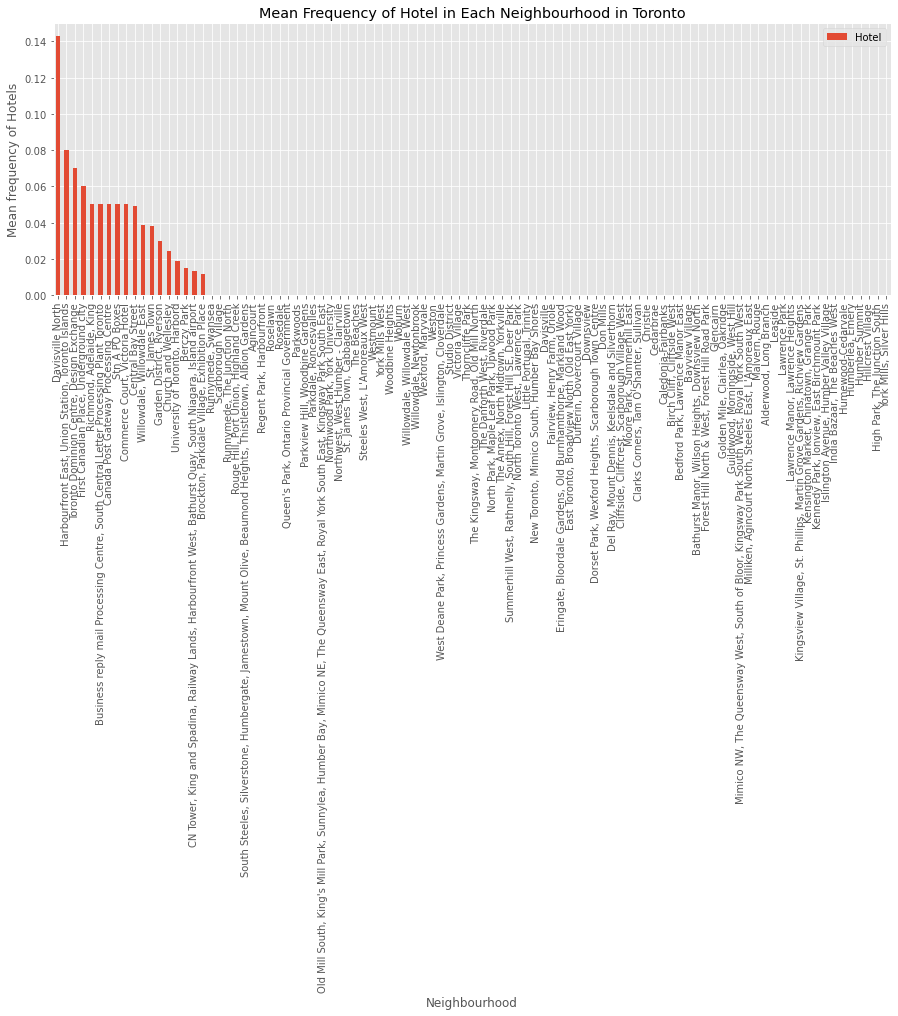

In [25]:
# sort by descending order
toronto_grouped_hotel.sort_values(by='Hotel', ascending=False, inplace=True)
toronto_grouped_rest.sort_values(by='Restaurant', ascending=False, inplace=True)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
toronto_grouped_hotel.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Hotel in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Hotels')

plt.show()

In [26]:
all_toronto_grouped = all_toronto_onehot.groupby('Neighbourhood').mean().reset_index()
all_toronto_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.153846,0.

In [27]:
all_toronto_grouped.shape

(98, 264)

In [28]:
num_top_venues = 5

for hood in all_toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = all_toronto_grouped[all_toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.15
1  Hong Kong Restaurant  0.08
2       Badminton Court  0.08
3        Discount Store  0.08
4         Shopping Mall  0.08


----Alderwood, Long Branch----
                   venue  freq
0      Convenience Store  0.25
1                    Pub  0.25
2  Performing Arts Venue  0.25
3                    Gym  0.25
4     Miscellaneous Shop  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Men's Store   0.5
1           Business Service   0.5
2                  Nightclub   0.0
3         Mexican Restaurant   0.0
4  Middle Eastern Restaurant   0.0


----Bayview Village----
                        venue  freq
0                       Trail   0.4
1  Construction & Landscaping   0.2
2          Golf Driving Range   0.2
3                        Park   0.2
4          Miscellaneous Shop   0.0


----Bedford Park, Lawrence Manor East----
                venue  freq
0

4  Convenience Store  0.17


----North Park, Maple Leaf Park, Upwood Park----
                venue  freq
0                Park  0.25
1               Trail  0.25
2              Bakery  0.25
3    Basketball Court  0.25
4  Miscellaneous Shop  0.00


----North Toronto West,  Lawrence Park----
                 venue  freq
0           Playground  0.33
1             Gym Pool  0.33
2                 Park  0.33
3  Monument / Landmark  0.00
4         Neighborhood  0.00


----Northwest, West Humber - Clairville----
             venue  freq
0  Auto Dealership  0.14
1              Gym  0.14
2   Sandwich Place  0.14
3      Gas Station  0.14
4       Restaurant  0.14


----Northwood Park, York University----
                    venue  freq
0  Furniture / Home Store  0.17
1           Metro Station  0.08
2                     Bar  0.08
3    Fast Food Restaurant  0.08
4                    Bank  0.08


----Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York S

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = all_toronto_grouped['Neighbourhood']

for ind in np.arange(all_toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Bubble Tea Shop,Hong Kong Restaurant,Supermarket,Bakery,Badminton Court,Discount Store,Sushi Restaurant,Grocery Store,Vietnamese Restaurant
1,"Alderwood, Long Branch",Convenience Store,Performing Arts Venue,Gym,Pub,Yoga Studio,Ethiopian Restaurant,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School
2,"Bathurst Manor, Wilson Heights, Downsview North",Men's Store,Business Service,Yoga Studio,Dry Cleaner,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
3,Bayview Village,Trail,Construction & Landscaping,Golf Driving Range,Park,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Pharmacy,Indian Restaurant,Comfort Food Restaurant,Pet Store,Cupcake Shop,Pub,Restaurant


In [31]:
df_prop_prep_clust = pd.merge(toronto_grouped_hotel, toronto_grouped_rest, how="left", on="Neighbourhood")

df_prop_prep_clust.head()

,Hotel,Restaurant
Neighbourhood,,
Davisville North,0.142857,0.00
"Harbourfront East, Union Station, Toronto Islands",0.080000,0.02
"Toronto Dominion Centre, Design Exchange",0.070000,0.04
"First Canadian Place, Underground city",0.060000,0.05
"Richmond, Adelaide, King",0.050000,0.05


In [32]:
df_prop_clust = pd.merge(df_prop_table, df_prop_prep_clust, how="left", on="Neighbourhood")


df_prop_clust.head()

,Neighbourhood,Price ($),Latitude,Longitude,Hotel,Restaurant
0,Agincourt,4.858069e+05,43.79452,-79.26708,0.0,0.000000
1,"Alderwood, Long Branch",9.331101e+05,43.60124,-79.53879,0.0,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",8.759328e+05,43.75788,-79.44847,0.0,0.000000
3,Bayview Village,6.717563e+05,43.78112,-79.38060,0.0,0.000000
4,"Bedford Park, Lawrence Manor East",2.037382e+06,43.73545,-79.41916,0.0,0.045455


In [33]:
#from sklearn.preprocessing import StandardScaler
#X = df_prop_clust.values[:,[1, 4]]
#X = np.nan_to_num(X)
#Clus_dataSet = StandardScaler().fit_transform(X)
#Clus_dataSet

In [34]:
#df_normalized = pd.DataFrame(Clus_dataSet)
#df_normalized.rename(columns={0:'Price', 1:'Freq of Hotels'}, inplace=True)
#df_normalized.head()

In [35]:
all_toronto_grouped_clustering = df_prop_clust.drop(['Neighbourhood', 'Latitude', 'Longitude'], axis = 1)
all_toronto_grouped_clustering.head()

,Price ($),Hotel,Restaurant
0,4.858069e+05,0.0,0.000000
1,9.331101e+05,0.0,0.000000
2,8.759328e+05,0.0,0.000000
3,6.717563e+05,0.0,0.000000
4,2.037382e+06,0.0,0.045455


In [36]:
from sklearn.preprocessing import StandardScaler
X = all_toronto_grouped_clustering.values[:,0:3]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-5.95278711e-01, -2.89071320e-01, -4.72427390e-01],
       [ 4.65515021e-02, -2.89071320e-01, -4.72427390e-01],
       [-3.54916047e-02, -2.89071320e-01, -4.72427390e-01],
       [-3.28462072e-01, -2.89071320e-01, -4.72427390e-01],
       [ 1.63105870e+00, -2.89071320e-01,  9.16303486e-01],
       [-1.10133336e-03,  4.64213834e-01,  4.53393194e-01],
       [-9.97057843e-02, -2.89071320e-01, -4.72427390e-01],
       [-4.74063689e-01,  2.89031240e-01,  9.48599553e-01],
       [-3.97567318e-01,  3.65097366e-01,  3.31574696e-01],
       [-2.61122997e-01, -2.89071320e-01, -4.72427390e-01],
       [-5.18446157e-01,  2.19676969e+00,  4.44134988e-01],
       [-5.29524040e-01, -2.89071320e-01, -4.72427390e-01],
       [ 4.71359616e-01, -2.89071320e-01, -4.72427390e-01],
       [-6.79000050e-01,  9.08924346e-01,  9.99961973e-01],
       [-6.19194923e-01, -2.89071320e-01, -4.72427390e-01],
       [ 1.92818327e-01, -2.89071320e-01,  2.58278054e+00],
       [ 3.27507653e-03,  2.19676969e+00

In [52]:
df_normalized = pd.DataFrame(Clus_dataSet)
df_normalized.rename(columns={0:'Price', 1:'Hotels', 2:'Restaurants'}, inplace=True)
df_normalized.head()

,Price,Hotels,Restaurants
0,-0.595279,-0.289071,-0.472427
1,0.046552,-0.289071,-0.472427
2,-0.035492,-0.289071,-0.472427
3,-0.328462,-0.289071,-0.472427
4,1.631059,-0.289071,0.916303


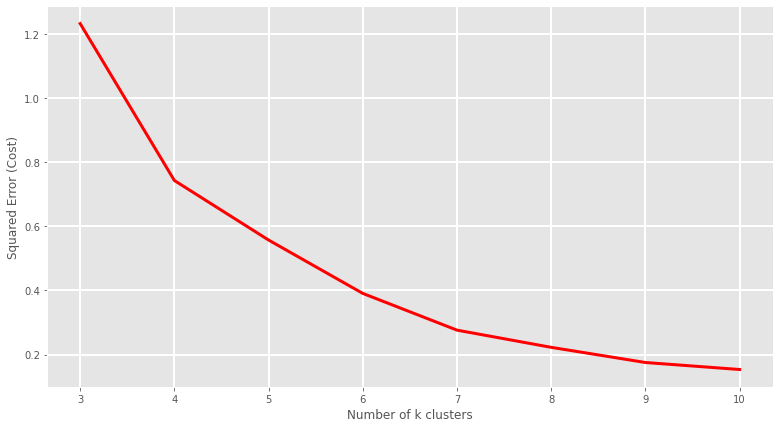

In [41]:
from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
    KM = KMeans(n_clusters=i, max_iter=100)
    KM.fit(df_normalized)

    # calculate squared error for the clustered points
    error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

In [42]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 3, 1, 1, 1, 1, 1], dtype=int32)

In [43]:
df_normalized.drop(['Price'], axis=1, inplace=True)
df_clustered = pd.merge(df_prop_table, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

In [44]:
df_clustered.head()

,Cluster Label,Neighbourhood,Price ($),Latitude,Longitude,Hotels,Restaurants
0,1,Agincourt,4.858069e+05,43.79452,-79.26708,-0.289071,-0.472427
1,1,"Alderwood, Long Branch",9.331101e+05,43.60124,-79.53879,-0.289071,-0.472427
2,1,"Bathurst Manor, Wilson Heights, Downsview North",8.759328e+05,43.75788,-79.44847,-0.289071,-0.472427
3,1,Bayview Village,6.717563e+05,43.78112,-79.38060,-0.289071,-0.472427
4,3,"Bedford Park, Lawrence Manor East",2.037382e+06,43.73545,-79.41916,-0.289071,0.916303


In [46]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude_toronto,longitude_toronto], zoom_start=11)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [47]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Price ($),Latitude,Longitude,Hotels,Restaurants
15,0,"Cliffside, Cliffcrest, Scarborough Village West",1.035046e+06,43.72360,-79.23496,-0.289071,2.582781
50,0,"Northwest, West Humber - Clairville",6.499990e+05,43.71174,-79.57941,-0.289071,3.892155
51,0,"Northwood Park, York University",5.190810e+05,43.76476,-79.48798,-0.289071,2.073579
62,0,Scarborough Village,6.319080e+05,43.74446,-79.23117,-0.289071,5.637988


Low Housing Price, Low Number of Hotels (competition), High amount of restaurants

In [48]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]

,Cluster Label,Neighbourhood,Price ($),Latitude,Longitude,Hotels,Restaurants
0,1,Agincourt,4.858069e+05,43.794520,-79.267080,-0.289071,-0.472427
1,1,"Alderwood, Long Branch",9.331101e+05,43.601240,-79.538790,-0.289071,-0.472427
2,1,"Bathurst Manor, Wilson Heights, Downsview North",8.759328e+05,43.757880,-79.448470,-0.289071,-0.472427
3,1,Bayview Village,6.717563e+05,43.781120,-79.380600,-0.289071,-0.472427
5,1,Berczy Park,8.999000e+05,43.645360,-79.373060,0.464214,0.453393
6,1,"Birch Cliff, Cliffside West",8.311808e+05,43.695100,-79.264660,-0.289071,-0.472427
7,1,"Brockton, Parkdale Village, Exhibition Place",5.702839e+05,43.639410,-79.426760,0.289031,0.948600
8,1,"CN Tower, King and Spadina, Railway Lands, Har...",6.235956e+05,43.640820,-79.398180,0.365097,0.331575
9,1,Caledonia-Fairbanks,7.186862e+05,43.687840,-79.450460,-0.289071,-0.472427
11,1,Cedarbrae,5.316326e+05,43.769440,-79.238920,-0.289071,-0.472427


Med Housing Price, Low Number of Hotels (competition), Low number of restaurants

In [49]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Price ($),Latitude,Longitude,Hotels,Restaurants
10,2,Canada Post Gateway Processing Centre,5.393529e+05,43.64869,-79.38544,2.196770,0.444135
16,2,"Commerce Court, Victoria Hotel",9.029500e+05,43.64840,-79.37914,2.196770,1.666218
18,2,Davisville North,1.305829e+06,43.71276,-79.38851,6.813332,-0.472427
30,2,"Harbourfront East, Union Station, Toronto Islands",9.042000e+05,43.64285,-79.38076,3.688274,0.138614
57,2,"Richmond, Adelaide, King",6.034694e+05,43.64970,-79.38258,2.196770,1.055177


Med Housing Price, High number of Hotels, Med number of Restuarants

In [50]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Price ($),Latitude,Longitude,Hotels,Restaurants
4,3,"Bedford Park, Lawrence Manor East",2.037382e+06,43.73545,-79.41916,-0.289071,0.916303
36,3,"Islington Avenue, Humber Valley Village",2.682881e+06,43.66263,-79.52831,-0.289071,-0.472427
42,3,Leaside,2.167378e+06,43.70902,-79.36349,-0.289071,0.453393
53,3,"Parkdale, Roncesvalles",1.886488e+06,43.64777,-79.44989,-0.289071,0.702653
58,3,Roselawn,3.589950e+06,43.71208,-79.41848,-0.289071,-0.472427
83,3,York Mills West,4.315027e+06,43.74778,-79.40033,-0.289071,-0.472427
84,3,"York Mills, Silver Hills",3.548245e+06,43.75698,-79.38060,-0.289071,-0.472427


High Housing Price, Low number of Hotels, Med number of Restaurants